## Dependencies

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image
import numpy as np
import pickle
import os

os.chdir("../data")

## Reduce dataset (optional)

In [53]:
cats, dogs = 0, 0
max_images = 1000
counter = {'cat': cats, 'dog': dogs}

for filename in os.listdir("cat_dog"):
    animal, number = filename.split(".")[:2]
    if counter[animal] >= max_images:
        path = os.path.join("cat_dog", filename)
        os.remove(path)
    else:
        counter[animal] += 1

## Preprocessing

In [3]:
if not os.path.exists("preprocessed"):
    os.makedirs("preprocessed")

files = os.listdir("cat_dog")
paths = [os.path.join("cat_dog", file) for file in files]
destinations = [os.path.join("preprocessed", file) for file in files]

for index, path in enumerate(paths):
    image = Image.open(path)
    image = image.convert('L').resize((64, 64))
    image.save(destinations[index])

## Train Test Split

In [8]:
if not os.path.exists("model_input"):
    os.makedirs("model_input")

classes = ['cat', 'dog']
files = os.listdir("preprocessed")
paths = [os.path.join("preprocessed", f) for f in files]
features = [np.array(Image.open(p)) for p in paths]
targets = [classes.index(f.split(".")[0]) for f in files]
targets = [[t, 1-t] for t in targets]

X = np.array(features)
y = np.array(targets)
X, y = shuffle(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

with open("model_input/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("model_input/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open("model_input/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)
with open("model_input/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

## Train model

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Input

model = Sequential()
model.add(Input(shape=(64,64,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [20]:
if not os.path.exists("model"):
    os.makedirs("model")

weights = model.get_weights()
pickle.dump(weights, open("model/model.pkl", "wb"))

## Evaluate model

<class 'list'>
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6987 - loss: 1.6453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: dog
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction: cat
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: dog
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction: cat
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: dog
Actual: dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: dog
Actual: cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: cat
Actual: cat


C:\Users\Thomas\AppData\Local\Temp\ipykernel_15392\237322370.py:26: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


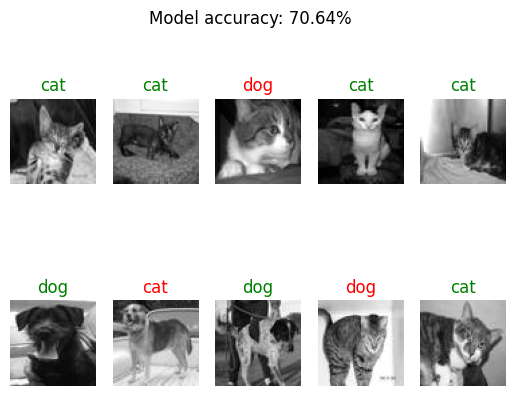

In [41]:
#plot the first 10 images and their predictions
import matplotlib.pyplot as plt

weights = pickle.load(open("model/model.pkl", "rb"))
print(type(weights))
model.set_weights(weights)

fig, axs = plt.subplots(2, 5)
accuracy = round(model.evaluate(X_test, y_test)[1] * 100,2)
fig.suptitle(f"Model accuracy: {accuracy}%")

classes = ['cat', 'dog']
for i in range(10):
    ax = axs[i//5, i%5]
    ax.imshow(X_test[i].reshape(64, 64), cmap='gray')
    prediction = model.predict(X_test[i].reshape(1, 64, 64, 1))
    prediction = classes[1-np.argmax(prediction[0])]
    actual = classes[(y_test[i][0])]
    print(f"Prediction: {prediction}")
    print(f"Actual: {actual}")
    ax.set_title(prediction, color='green' if prediction == actual else 'red')
    ax.axis('off')

#convert to pil
fig.canvas.draw()
image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

if not os.path.exists("model"):
    os.makedirs("model")

image.save("model/evaluation.png")

In [22]:
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy: ", round(accuracy * 100, 2))

[1.6348977088928223, 0.7063999772071838]
Accuracy:  70.64


In [234]:
model.save("catdog.keras")